Generating simulated hourly data for March 2024...
Simulated data head:
                     HourOfDay  DayOfWeek  DayOfMonth        LMP  \
2024-03-01 00:00:00          0          4           1  29.522069   
2024-03-01 01:00:00          1          4           1  34.921539   
2024-03-01 02:00:00          2          4           1  39.756958   
2024-03-01 03:00:00          3          4           1  40.449669   
2024-03-01 04:00:00          4          4           1  42.717907   

                          Load_MW  Temperature_F   Wind_Gen_MW  Solar_Gen_MW  \
2024-03-01 00:00:00  41501.540031      62.551236  16813.885618           0.0   
2024-03-01 01:00:00  44980.702312      66.964214  15094.373890           0.0   
2024-03-01 02:00:00  49764.419356      59.191567  15516.156020           0.0   
2024-03-01 03:00:00  56104.905483      61.405048  14733.775076           0.0   
2024-03-01 04:00:00  56384.675621      54.900906  13206.921481           0.0   

                     NatGasPrice_$/MMB

C:\Users\gangl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                LMP   No. Observations:                  600
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -2524.870
Date:                            Thu, 05 Jun 2025   AIC                           5077.740
Time:                                    07:57:10   BIC                           5138.054
Sample:                                03-01-2024   HQIC                          5101.312
                                     - 03-25-2024                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Load_MW                -0.0004      0.002     -0.190      0.850      -0.004       0.003
Temperat

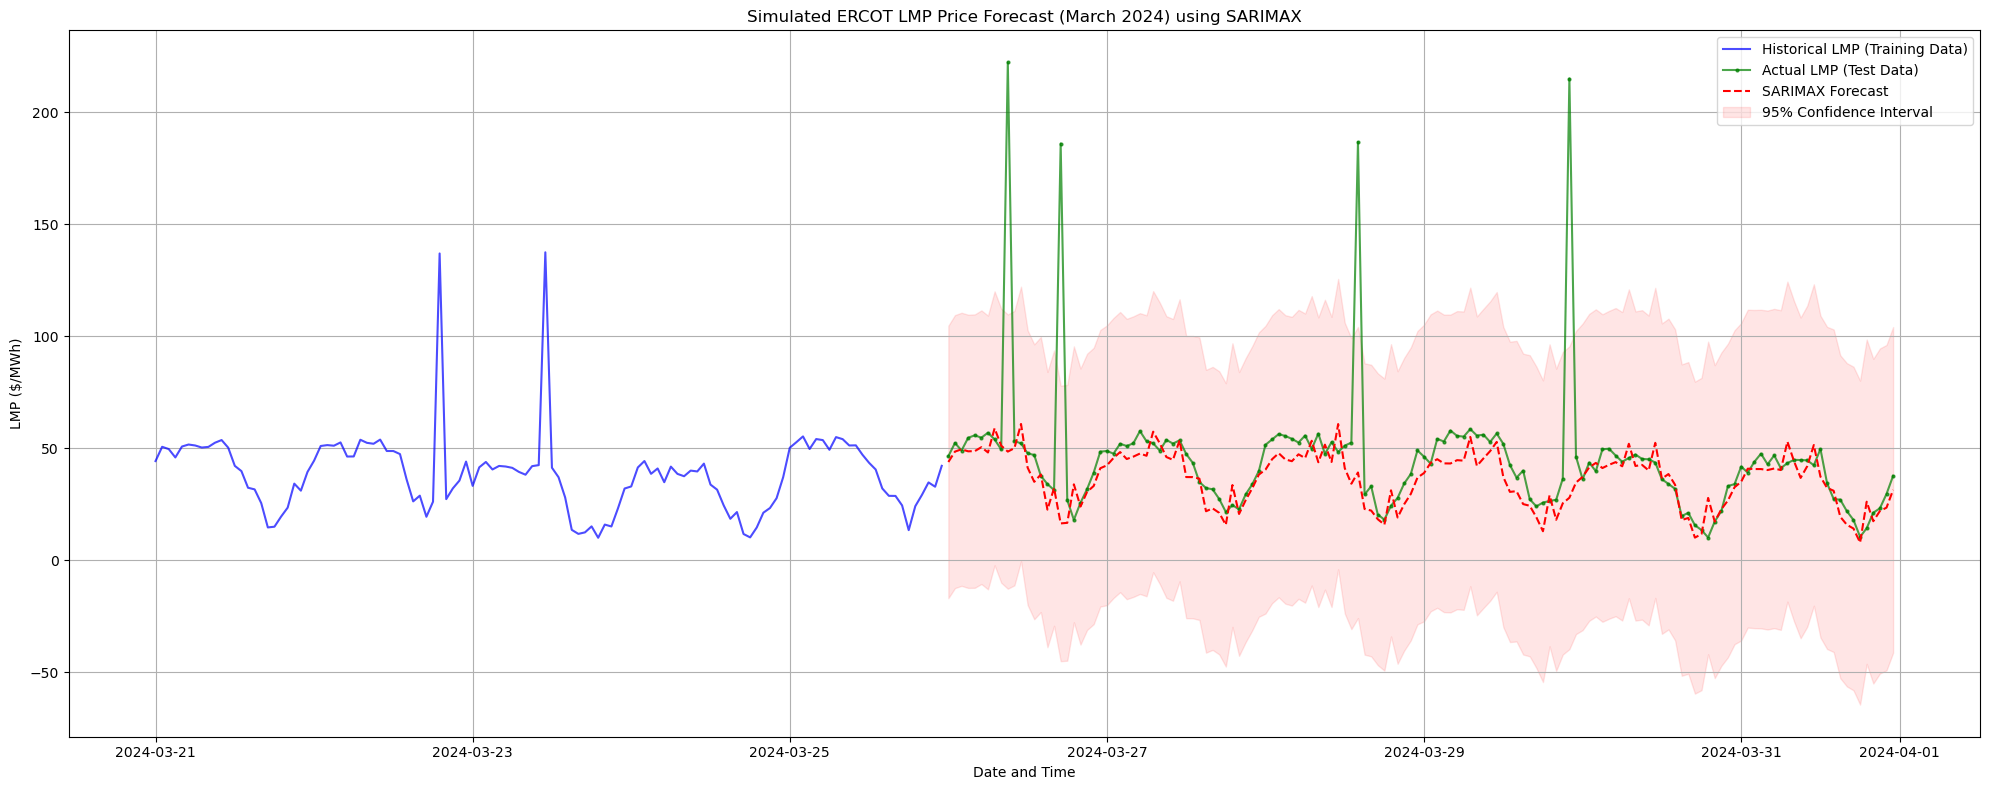


--- SARIMAX Forecasting Example Complete ---


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Generate Simulated Hourly Data for March 2024 ---
print("Generating simulated hourly data for March 2024...")

start_of_month = datetime(2024, 3, 1, 0, 0)
end_of_month = datetime(2024, 3, 31, 23, 0) # End of March 2024
num_hours = (end_of_month - start_of_month).days * 24 + (end_of_month - start_of_month).seconds // 3600 + 1
dates = pd.date_range(start=start_of_month, periods=num_hours, freq='H')

price_data = pd.DataFrame(index=dates)
price_data['HourOfDay'] = price_data.index.hour
price_data['DayOfWeek'] = price_data.index.dayofweek # Monday=0, Sunday=6
price_data['DayOfMonth'] = price_data.index.day

# Base LMP with an upward trend and some noise
base_lmp = np.linspace(30, 45, num_hours) + np.random.normal(0, 3, num_hours)

# Daily seasonality (peaks in morning/evening, lows overnight)
daily_seasonality = 15 * np.sin(price_data['HourOfDay'] * 2 * np.pi / 24) + \
                    5 * np.cos(price_data['HourOfDay'] * 4 * np.pi / 24)

# Weekly seasonality (e.g., lower on weekends)
weekly_seasonality = -10 * (price_data['DayOfWeek'] >= 5) # -10 for Sat/Sun

# Price spikes (simulating market events/congestion)
spikes = np.zeros(num_hours)
# Random spikes
np.random.seed(42) # for reproducibility
spike_hours = np.random.choice(num_hours, size=int(num_hours * 0.02), replace=False)
spikes[spike_hours] = np.random.uniform(50, 200, size=len(spike_hours)) # Moderate spikes

# Combine to form LMP
price_data['LMP'] = base_lmp + daily_seasonality + weekly_seasonality + spikes
price_data['LMP'] = np.maximum(0.01, price_data['LMP']) # Ensure positive prices

# --- Simulated Exogenous Variables ---
# These are crucial for SARIMAX and would come from actual forecasts in a real scenario.
price_data['Load_MW'] = 50000 + 15000 * np.sin(price_data['HourOfDay'] * 2 * np.pi / 24 - np.pi/4) + \
                        500 * price_data['DayOfWeek'] + np.random.normal(0, 2000, num_hours)
price_data['Load_MW'] = np.maximum(30000, price_data['Load_MW'])

price_data['Temperature_F'] = 45 + 15 * np.sin(price_data['HourOfDay'] * 2 * np.pi / 24 + np.pi/2) + \
                              10 * np.sin(price_data['DayOfMonth'] * 2 * np.pi / 31) + \
                              np.random.normal(0, 3, num_hours) # Simulating increasing temps through March
price_data['Temperature_F'] = np.maximum(20, price_data['Temperature_F'])

price_data['Wind_Gen_MW'] = 10000 + 5000 * np.cos(price_data['HourOfDay'] * 2 * np.pi / 24) + \
                            2000 * np.random.rand(num_hours)
price_data['Wind_Gen_MW'] = np.maximum(0, price_data['Wind_Gen_MW']) # Cannot be negative

price_data['Solar_Gen_MW'] = np.zeros(num_hours)
daytime_hours = (price_data['HourOfDay'] >= 7) & (price_data['HourOfDay'] <= 18)
price_data.loc[daytime_hours, 'Solar_Gen_MW'] = \
    3000 + 2000 * np.sin((price_data['HourOfDay'][daytime_hours] - 7) * np.pi / 12) + \
    500 * np.random.rand(np.sum(daytime_hours))
price_data['Solar_Gen_MW'] = np.maximum(0, price_data['Solar_Gen_MW'])

price_data['NatGasPrice_$/MMBtu'] = 2.0 + 0.2 * np.random.randn(num_hours) + \
                                   0.05 * (price_data.index - price_data.index.min()).days / 31 # Slight upward trend
price_data['NatGasPrice_$/MMBtu'] = np.maximum(1.5, price_data['NatGasPrice_$/MMBtu'])

print("Simulated data head:")
print(price_data.head())
print("\nData description:")
print(price_data.describe())

# --- 2. Feature Engineering (for Exogenous Variables) ---
# For SARIMAX, we use the raw exogenous variables.
# We will define the exogenous variables to be used in the model.
exog_features = ['Load_MW', 'Temperature_F', 'Wind_Gen_MW', 'Solar_Gen_MW', 'NatGasPrice_$/MMBtu',
                 'HourOfDay', 'DayOfWeek', 'DayOfMonth'] # Include temporal features as exogenous too

# --- 3. SARIMAX Model Training ---
print("\n--- SARIMAX Model Training ---")

# Define target variable
target = 'LMP'

# Split data into training and testing sets chronologically
# Let's use the first 25 days for training and the last 6 days for testing (forecasting)
train_end_date = start_of_month + timedelta(days=24, hours=23) # End of March 25th
train_data = price_data.loc[start_of_month:train_end_date]
test_data = price_data.loc[train_end_date + timedelta(hours=1):end_of_month]

# Ensure there's data in test set
if test_data.empty:
    print("Test data is empty. Adjusting split to ensure test data exists.")
    split_ratio = 0.8 # Use 80% for training
    split_point = int(len(price_data) * split_ratio)
    train_data = price_data.iloc[:split_point]
    test_data = price_data.iloc[split_point:]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()} (Shape: {train_data.shape})")
print(f"Test data from {test_data.index.min()} to {test_data.index.max()} (Shape: {test_data.shape})")

# Determine SARIMAX orders (p,d,q)(P,D,Q,S)
# This is often the hardest part. Common for hourly data:
# S = 24 (daily seasonality)
# S = 24*7 = 168 (weekly seasonality) - Could be very slow for `statsmodels`
# For this example, let's use daily seasonality (S=24)
p, d, q = 2, 1, 1 # Non-seasonal orders (AR, Integrated, MA)
P, D, Q, S = 1, 1, 1, 24 # Seasonal orders (Seasonal AR, Integrated, MA, Period)

print(f"SARIMAX Orders: Non-seasonal={p,d,q}, Seasonal={P,D,Q,S}")

# Fit SARIMAX model
# Using exogenous variables from the training set
sarimax_model = sm.tsa.statespace.SARIMAX(train_data[target],
                                          exog=train_data[exog_features],
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, S),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False) # disp=False to suppress verbose optimization output
print(sarimax_results.summary())

# --- 4. Forecasting ---
print(f"\n--- Forecasting for {len(test_data)} hours ---")

# For forecasting with exogenous variables, you MUST provide future values of these variables.
# In a real-world scenario, these would be *forecasts* of Load, Temp, Wind, Solar, NatGasPrice,
# and known future values for HourOfDay, DayOfWeek, DayOfMonth.
future_exog = test_data[exog_features]

# Generate forecasts
sarimax_forecast = sarimax_results.get_forecast(steps=len(test_data), exog=future_exog)
forecast_mean = sarimax_forecast.predicted_mean
conf_int = sarimax_forecast.conf_int(alpha=0.05) # 95% confidence interval

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame({'Predicted_LMP': forecast_mean,
                            'LMP_Lower': conf_int[f'lower {target}'],
                            'LMP_Upper': conf_int[f'upper {target}']},
                           index=test_data.index)

print("\nForecast (first 5 values):")
print(forecast_df.head())

# --- 5. Evaluation ---
print("\n--- Evaluation ---")

y_true = test_data[target]
y_pred = forecast_df['Predicted_LMP']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# MAPE can be problematic with prices near zero or highly volatile data
# mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} $/MWh")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} $/MWh")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R2): {r2:.3f}")


# --- 6. Visualization ---
print("\n--- Visualizing Forecast ---")

plt.figure(figsize=(20, 8))
# Plot training data (a recent segment)
plt.plot(train_data.index[-24*5:], train_data[target].iloc[-24*5:], label='Historical LMP (Training Data)', color='blue', alpha=0.7)
# Plot actual test data
plt.plot(test_data.index, y_true, label='Actual LMP (Test Data)', color='green', marker='.', markersize=4, alpha=0.7)
# Plot forecasted data
plt.plot(forecast_df.index, forecast_df['Predicted_LMP'], label='SARIMAX Forecast', color='red', linestyle='--')
# Plot confidence intervals
plt.fill_between(forecast_df.index, forecast_df['LMP_Lower'], forecast_df['LMP_Upper'], color='red', alpha=0.1, label='95% Confidence Interval')

plt.title('Simulated ERCOT LMP Price Forecast (March 2024) using SARIMAX')
plt.xlabel('Date and Time')
plt.ylabel('LMP ($/MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- SARIMAX Forecasting Example Complete ---")